# Main things we will need to import

In [1]:
# import block
import numpy as np
from astropy.io import fits
%matplotlib inline
from matplotlib import pyplot as plt
from astropy.visualization import hist
import ccdproc as ccdp
from matplotlib import rc

# for fitting models
from astropy.modeling import fitting
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D

#from ccdproc import ImageFileCollection
#from astropy.modeling import fitting
#from astropy.stats import mad_std
#from astropy.nddata import CCDData
#from scipy import stats
#from astropy import units as u

# Makes plots prettier

In [2]:
# plotting defaults
# Use custom style for larger fonts and figures
phot_tutorial_dir = '/Users/palladl2/Desktop/projects/phot-tutorials/ccd-reduction-and-photometry-guide/notebooks/'
plt.style.use(phot_tutorial_dir+'guide.mplstyle')

# Set some default parameters for the plots below
rc('font', size=12)
rc('axes', grid=True)

#

In [3]:
# define directories
data_dir = '/Users/palladl2/Desktop/Fall 2021/Vandy Courses/Observational Tech/reductions/Imaging/'
reduced_dir = '/Users/palladl2/Desktop/Fall 2021/Vandy Courses/Observational Tech/reductions/reduced/Imaging/'

In [4]:
# make an array of your bias filenames
# you can do this efficiently as a loop if they are all taken in a row
# you will need to update the numbers below to correctly list bias files
nfiles = 19 # number of files in a sequence
nlow   = 93  # the exposure number for the first file 

bias_files = [reduced_dir+'a'+str(i).zfill(3)+'.fits' for i in np.arange(nfiles)+nlow]

# you can use list comprehension when you need to do something many times
# one example is to use it to open all the bias files and headers
hdus = [fits.open(file) for file in bias_files]
hdrs = [hdu[0].header for hdu in hdus]
biases = [hdu[0].data for hdu in hdus]

In [5]:
np.shape(biases[0:2])

(2, 2048, 2200)

In [6]:
# inspect the hdrs and biases
# can you print the EXPTIME keyword for the second bias frame?
#hdrs

In [7]:
for i in range(np.size(hdus)):
    print(i) # place holder for loop
    
    hdrs[i]['BIASSEC'] = '[0:2048,2102:2200]' # add header keywords for BIASSEC, TRIMSEC, FILTER, and IMAGETYP
    hdrs[i]['TRIMSEC'] = '[0:2048,55:2102]'
    hdrs[i]['FILTER'] = "NONE"
    hdrs[i]['IMAGETYP'] = "BIAS"
    hdus[i].writeto(bias_files[i], overwrite = True) # write the fits file out with the new header keywords
    # note that you have to write out the whole HDU - i.e. the data+header package  
    
del hdus # hdus take a lot of memory, don't leave them open when you don't need to
del hdrs

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [26]:
# read in one of your fits files
# print its header and check that the new keywords are there
ao3 =  fits.open('/Users/palladl2/Desktop/Fall 2021/Vandy Courses/Observational Tech/reductions/reduced/Imaging/a093.fits')
ao3[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2200 / Axis length                                    
NAXIS2  =                 2048 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =                    1 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =                32768                                                  
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2009-09-15T15:56:40' / Date FITS file was generated                  
IRAF-TLM= '09:56:39 (15/09/2009)' / Time of last modification                   
DATAMIN =           5.720000E2 / Minimum data value                             
DATAMAX =           7.536000

In [30]:
# read in the a093 bias frame
bias_fake = np.ones(np.shape(biases[0])[0:]) # this placeholder is an array of ones shaped like your images
bias = (biases[0])

In [53]:
# select the overscan region
# you may want to use DS9 on a flat frame to find the relevant rows/cols
# it should be the same for all frames taken in this data set

# use these variables to specify the 
# row and col range for the overscan 
# you can rename them to row and col 
# if you figure out which is which
lo1 = 0
hi1 = 2048
lo2 = 2102
hi2 = 2200

# find the mean and median bias values in the overscan region
# do this by collapsing the columns in the overscan
bias_mn = np.mean(bias[lo1:hi1,lo2:hi2],axis=1)
bias_md = np.median(bias[lo1:hi1,lo2:hi2],axis=1)

# determine whether to use average or median to collapse columns
print('The mean has smaller rms ({0:4.2f}) than the median ({1:4.2f}).'.format(np.std(bias_mn),np.std(bias_md)))

The mean has smaller rms (0.40) than the median (0.48).


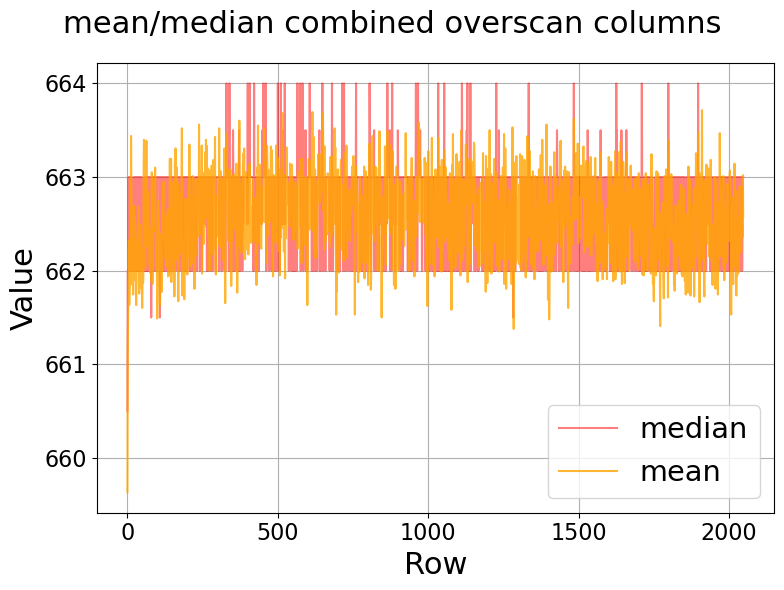

In [54]:
# plot the mean and median bias value in the overscan region

# make an array for the rows
rows_in_overscan = np.shape(bias_mn)[0] # how many rows are in the overscan region?
rows = np.arange(rows_in_overscan)

# make the plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(rows,bias_md,ls='-',c='r',label='median',alpha=0.5)
ax.plot(rows,bias_mn,ls='-',c='orange',label='mean',alpha=0.8)
ax.legend()
ax.set_xlabel(r'Row',fontsize=22)
ax.set_ylabel(r'Value',fontsize=22)
fig.suptitle('mean/median combined overscan columns', fontsize=22)
fig.tight_layout()
plt.show()

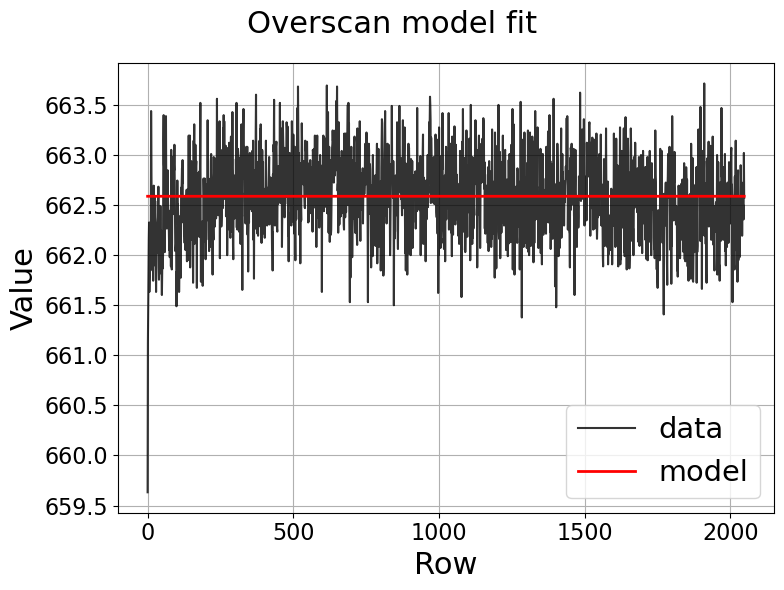

In [55]:
# define a minimization method
# some options are LinearLSQFitter(), SimplexLSQFitter(), LevMarLSQFitter()
# not all minimizers work on all problems, so experiment
fitter = fitting.LinearLSQFitter()
fitter2 = fitting.SimplexLSQFitter()
fitter3 = fitting.LevMarLSQFitter()

# choose a model
# these are from the import block
# options are Polynomial1D,Chebyshev1D,Legendre1D 
# they generally take the polynomial order as an input
# but see their inputs here: https://docs.astropy.org/en/stable/modeling/polynomial_models.html
degree = 0 # this will be a constant
#model = Polynomial1D(degree)
#model = Chebyshev1D(degree)
model = Legendre1D(degree)

# set up the inputs
xvals = rows
yvals = bias_mn
wgts  = np.ones_like(bias_mn) # weight all the same

# find the best fit
best_fit = fitter(model, xvals, yvals, weights=wgts)    

# plot it
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(xvals,yvals,ls='-',c='k',label='data',alpha=0.8)
ax.plot(xvals,best_fit(xvals),ls='-',lw=2,c='r',alpha=1,label='model')
ax.legend()
ax.set_xlabel(r'Row',fontsize=22)
ax.set_ylabel(r'Value',fontsize=22)
fig.suptitle('Overscan model fit', fontsize=22)
fig.tight_layout()
plt.show()

In [56]:
# open your images as an ImageCollection, 
# isolate the biases, and check that your 
# new header keywords are present

# note that the include/exclude options can be useful for grabbing only specific files
# for example, you could grab all your bias-subtracted images with glob_include='*otz.fits'
# but we haven't done anything yet, so open everything to start
imgs = ccdp.ImageFileCollection(reduced_dir,glob_include='*.fits',glob_exclude='master*') 

In [42]:
# explore the image collection, try uncommenting each of the following:
# (do them one at a time, you'll get a nicely formatted print without 
# including a print statement if it's the last thing in the cell)

dir(imgs)     # this will print all the things associated with an image collection
imgs.keywords # this is a list of available header keywords, good thing you added some!
imgs.summary   # summary table

file,simple,bitpix,naxis,naxis1,naxis2,extend,bscale,bzero,origin,date,iraf-tlm,datamin,datamax,object,date-obs,timesys,observat,sidetime,objepoch,airmass,exptime,ha,telescop,instrume,filter1,filter2,telra,teldec,observer,comment,biassec,trimsec,filter,imagetyp
str9,bool,int64,int64,int64,int64,bool,float64,float64,str37,str19,str21,float64,float64,str7,str23,str3,str11,str10,float64,float64,float64,str11,str9,str10,str4,str4,str11,str12,str8,str19,object,object,object,object
a001.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:16,09:55:15 (15/09/2009),0.0,65535.0,SERVICE,2009-06-23T01:43:32.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,3.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None",--,--,--,--
a002.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:16,09:55:16 (15/09/2009),0.0,65535.0,SERVICE,2009-06-23T01:44:22.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,3.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None",--,--,--,--
a003.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:17,09:55:16 (15/09/2009),0.0,65535.0,SERVICE,2009-06-23T01:44:52.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None",--,--,--,--
a004.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:17,09:55:17 (15/09/2009),0.0,65535.0,SERVICE,2009-06-23T01:45:32.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None",--,--,--,--
a005.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:18,09:55:17 (15/09/2009),0.0,50846.0,SERVICE,2009-06-23T01:47:01.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None",--,--,--,--
a006.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:19,09:55:18 (15/09/2009),0.0,50217.0,SERVICE,2009-06-23T01:47:41.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None",--,--,--,--
a007.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:55:19,09:55:19 (15/09/2009),0.0,49940.0,SERVICE,2009-06-23T01:48:27.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,1.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,"None,None,None,None",--,--,--,--
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d009.fits,True,16,2,2200,2048,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2007-10-10T18:19:03,12:19:03 (10/10/2007),613.0,1792.0,FOLLOW,2007-08-21T10:42:54.000,UTC,Observatory,21:39:2.85,2000.0,1.2370202634986582,5.0,-2:50:57.12,Telescope,Instrument,None,None,0:29:59.97,29:59:59.96,Observer,"None,None,None,None",--,--,--,--
